# RES Tesseract Extraction

## The Tesseract library

I use Tesseract, a popular parsing library and the python binding of it pyTesseract to parse RES documents in this section. I am  following the code and technique from this article on how to read a multi-column pdf. The fitz python module is a lightweight pdf reader, it will require the installation of pyMupdf. OpenCV python module and the module/class cv2 from it is used to apply otsu's thresholding technique to lift/determine paragraph edges. 

https://towardsdatascience.com/read-a-multi-column-pdf-with-pytesseract-in-python-1d99015f887a

In [20]:
import fitz

# for OCR using PyTesseract
import cv2                              # pre-processing images
import pytesseract                      # extracting text from images
import numpy as np
import matplotlib.pyplot as plt         # displaying output images
from PIL import Image
import regex
import pandas as pd
import time
import os

Set path to where pdfs of articles are.

In [4]:
base_path="/Users/sijiawu/Work/Refs Danae/Thesis/Data"
temp=base_path+'/PDFs/RES/'

Read in the merged pdf containing jstor, scopus and datadump metadata.

In [5]:
Merged=pd.read_excel(base_path+'/Combined/RES_M_sco_du.xlsx')
Merged.loc[Merged['journal']=="The Review of Economic Studies",'journal']='RES'

Set the zoom factor to zoom into the pdf. This is to get a higher resolution image. I have chosen 3x zoom for both vertically and horizontally.

In [6]:
zoom_x = 2.0 # horizontal zoom
zoom_y = 2.0 # vertical zoom
mat = fitz.Matrix(zoom_x, zoom_y)

### The converter() function
This function takes a string and replaces all non-ascii characters with a placeholder. In regex, a placeholder is represented by a '.'. Specific to JPE, a lower case 'L' and a upper case 'I' look the same to tesseract because of the font. Hence, upper case 'I's are replaced with a placeholder. I found that for middle name initials, tesseract may mistake the letter for something else  hence again, we replace it with a placeholder. 

An alternative solution is to use fuzzy matching.

In [7]:
import string
def converter(teststring):
    teststring=teststring.replace('.','[.]')
    print(teststring)
    #for i in range(len(teststring)):
    #    if teststring[i] == '.':
    #        teststring=teststring[0:i-1]+'.'+teststring[i:]
    #teststring=teststring.replace('I','.')
            
    for i in teststring:
        if (i not in string.ascii_lowercase) & (i not in string.ascii_uppercase) & (i !=' ') & (i!='.') & (i!='[') & (i!=']'):
            teststring=teststring.replace(i,'.')
    return teststring


In [8]:
x=converter('A. mann')
print(x)
x='CHIOU.SHUANG YAN'
print(regex.search('('+x+'.){e<=3}','CHIOU-SHUANG YAN and'))


A[.] mann
A[.] mann
<regex.Match object; span=(0, 17), match='CHIOU-SHUANG YAN '>


In [3]:
def getNumberofPages(text):
    if pd.isna(text)==False:
        if re.search('\d',text):
            temp=text.split(',')
            pages=0
            print(temp)
            for m in temp:
                if '-' in m:
                    t=str(m).split('-')
                    pages=pages+int(re.sub('\D','',t[1]))-int(re.sub('\D','',t[0]))+1
                else:
                    pages+=1
            return pages
    return 1

### The generate_pngs() function
This function looks for the block of text that contains author names, assuming that the block also contains affiliations. If affiliations are not found, then the parsed text is returned. Since RES has it's affiliations at the end of the article and in the same line as the author name. It is simply easier to parse everything 

Given a pdf file path (SCANNED_FILE), the number of pages (pages), zoom matrix (mat), path to pdf file folder (path). You can uncomment the lines of code for plots inside the function to see pages that have been parsed or the output. Lastly, a string or regex pattern that would match the lead author's name.

In [12]:
def generate_pngs(SCANNED_FILE, mat, path, author):
    doc = fitz.open(SCANNED_FILE)
    parsed={} #set up storage if something is not found
    for page in reversed(doc):
        if (page.number>=doc.page_count-20):
            png = path+"\\" + Merged.iloc[i]['stable_url'].split('/')[-1].split('.')[0] + '_page-%i.png' % page.number
            print(png) #show path
            if os.path.exists(png)==False:
                pix = page.get_pixmap(matrix=mat)
                pix.save(png)
                
            parsed[page.number]=[]

            original_image = cv2.imread(png)
            print(original_image.shape)
            '''
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
            
            plt.figure(figsize=(25, 15))
            plt.imshow(gray_image, cmap='gray')
            plt.show()
            '''
            # Creating a copy of the image
            copied_image = original_image.copy()


            # Apply OCR on the cropped image
            text = pytesseract.image_to_string(copied_image, lang='lat', config='--oem 3 --psm 4')
            #print(i)
            #print(text)
            if re.search('AUTHOR\(S\)', text.upper()) is not None:
                continue
                
            parsed[page.number].append(text)
            print(regex.search(author, text.upper()))
            if regex.search(author, text.upper()) is not None:
                print('found')
                #print(text)
                return({'found': text})
            #i=i+1
    return {'raw': parsed}

In [17]:
def generate_pngs2(SCANNED_FILE, pages, mat, path, k_val, author):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    count=doc.page_count-pages
    if count<0:
        count=1
    for page in doc:
        if (page.number == count):
            png = path+'\\'+ SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
            if os.path.exists(png)==False:
                pix = page.get_pixmap(matrix=mat)
                print(png)
                pix.save(png)

            parsed[page.number]=[]

            original_image = cv2.imread(png)
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(gray_image, cmap='gray')
            #plt.show()

            # Performing OTSU threshold
            ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(threshold_image, cmap='gray')
            #plt.show()

            rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

            # Applying dilation on the threshold image
            dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(dilated_image)
            #plt.show()

            # Finding contours
            contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Creating a copy of the image
            copied_image = original_image.copy()

            mask = np.zeros(original_image.shape, np.uint8)
            i=1
            # Looping through the identified contours
            # Then rectangular part is cropped and passed on to pytesseract
            # pytesseract extracts the text inside each contours
            # Extracted text is then written into a text file
            for cnt in reversed(contours):
                x, y, w, h = cv2.boundingRect(cnt)
                print(i)
                # Cropping the text block for giving input to OCR
                cropped = copied_image[y:y + h, x:x + w]
                # Apply OCR on the cropped image
                text = pytesseract.image_to_string(cropped, lang='lat', config='--oem 3 --psm 1')
                print(text)
                parsed[page.number].append(text)
                print(re.search(author.upper(),text.upper()))
                if regex.search('AUTHOR\(S\)', text.upper()) is not None:
                    count+=1
                    break
                if regex.search(author.upper(),text.upper()) is not None:
                    return {'found': text}
                #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                print()
                i=i+1
            #plt.figure(figsize=(25, 15))
            #plt.imshow(masked, cmap='gray')
            #plt.show()
    return {'raw': parsed}

Walter Perrin Heller


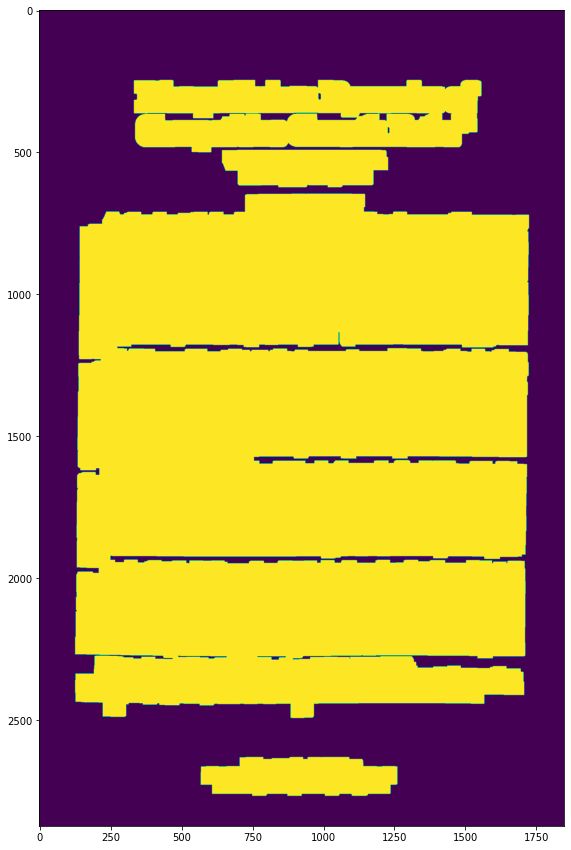

1

None

2

None

3

None

4

None

5
Disequilibrium Dynamics of
Competitive Growth Paths"

None

6
WALTER PERRIN HELLER
University of Pennsylvania

<re.Match object; span=(0, 20), match='WALTER PERRIN HELLER'>
2.5648820400238037


{'found': 'WALTER PERRIN HELLER\nUniversity of Pennsylvania\n'}

In [14]:
# replace with you own file
SCANNED_FILE = path+'\\2296685.pdf'

t0=time.time()        
affiliations=generate_pngs2(SCANNED_FILE, 16, mat, path, 45, converter('Walter Perrin Heller'))
t1=time.time()
total=t1-t0
print(total)
affiliations

In [15]:
dict={}

In [492]:
t0=time.time()

for i in Merged[(Merged['year']>=1940) & (Merged['year']<=1970) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')].index:
    if Merged.iloc[i]['Jstor_authors'] is not NaN: 
        if "Suggested by" not in Merged.iloc[i]['Jstor_authors']:
            authors=str(Merged.iloc[i]['Jstor_authors']).replace(' and ',', ').replace("  ",' ').split(',')
            filepath=path+'\\'+Merged.iloc[i]['stable_url'].split('/')[-1]+'.pdf'
            if os.path.exists(filepath)==True:
                print(Merged.iloc[i]['year'])
                first_author=converter(authors[0].upper().strip())
                print(first_author)
                affiliations=generate_pngs(filepath, mat, path, '('+first_author+'.){e<=4}\n')
                print(affiliations)
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]={'affiliations': affiliations, 
                                                                   'content_type': Merged.iloc[i]['content_type'], 
                                                                   'authors': authors, 
                                                                   'stable_url': Merged.iloc[i]['stable_url']}
            else:
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['stable_url']
t1=time.time()
total=t1-t0
print(total)
print(i)

1970
G[.] L[.] REUBER
G[.] L[.] REUBER
D:\docs\Masters\Data\RES_data\2296479_page-20.png
(2920, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296479_page-19.png
(2920, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296479_page-18.png
(2920, 1853, 3)
<regex.Match object; span=(3622, 3639), match='IO G. L. REUBER\n\n', fuzzy_counts=(1, 3, 0)>
found
{'found': "466 REVIEW OF ECONOMIC STUDIES\n\nresult directly points up a major difficulty: the lack of a satisfactory method for testing\nthe validity of this hypothesis in relation to other explanations of changes in wages.!\n\n4. CONCLUDING COMMENTS\n\nThe principal purpose of this paper has been to identify the primary determinants of\nmoney wage changes in Canadian manufacturing industries at the two-digit level of dis-\naggregation. Although the evidence is subject to several limitations, it is generally consistent\nwith the view that in the majority of industries wage changes are associated with changes\nin the relative wage (i.e., the indu

None
D:\docs\Masters\Data\RES_data\2296481_page-17.png
(2920, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296481_page-16.png
(2920, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296481_page-15.png
(2920, 1853, 3)
<regex.Match object; span=(2377, 2393), match='IA J. HELLIWELL\n', fuzzy_counts=(0, 3, 1)>
found
{'found': 'FORWARD-LOOKING INVESTMENT BEHAVIOUR 513\n\ndoes not forecast 1966-68 as well. The realizations model fits the data period much better\nthan either, but still does not perform as well as the survey 1966-68. The realizations equa-\ntion has an average annual percentage error of 5:6 per cent, compared to 4:1 per cent for\nthe current dollar investment survey.\n\nFor INRC the forecast model (based on INRCSC) fits the data period so much better\nthan either the survey or the equation based on /NRCC that the combined forecast model\nattaches no importance to the new information represented by the survey. Even the\nrealizations function does not fit the data as well as the cal

None
D:\docs\Masters\Data\RES_data\2296484_page-10.png
(2920, 1853, 3)
<regex.Match object; span=(347, 363), match=' J. E. SRIGUITZ\n', fuzzy_counts=(2, 1, 1)>
found
{'found': '552 REVIEW OF ECONOMIC STUDIES\n\nbe equal every period if and only if\n\n(a4, — y)04 7 HxPx— ByDy all t\nie. Q4, — ay,, the two sectors have identical labour requirements. (See Fig. 4.) In fact,\n\nby appropriate choice of units ju, — u,; the two sectors must have identical production\nfunctions.\n\ne machine x\n\no o machine y\n\nFIGURE 4\n\nCowles Foundation J. E. SriGuITZ\nYale University\n\nFirst version received August 1968; final version received November 1969\n\nREFERENCES\n\n[1] Arrow, K. J. * Alternative Proof of the Substitution Theorem for Leontief Models\nin the General Case ", Chapter IX in T. C. Koopmans, Activity Analysis of. Pro-\nduction and Allocation (Cowles Foundation Monograph 13, 1951).\n\n[2] Burmeister, E., and Sheshinski, E. ** A Non-Substitution Theorem in a Model\nwith Fixed Capital "

None
D:\docs\Masters\Data\RES_data\2296487_page-4.png
(2920, 1853, 3)
<regex.Match object; span=(2009, 2032), match='TO W. R. S. SUTHERLAND\n', fuzzy_counts=(0, 3, 1)>
found
{'found': '588 REVIEW OF ECONOMIC STUDIES\n\nProof. Let [x, y] be any other programme from y\', and T» 1 be an integer. Then\nusing the support property for each (x,, y;),\n\nT T\nX, 87s y)- Y nus y)\n- t-\n\nT\nS px-y) Y, 97 pou yi) £9 p! — yr)\n\nsz ó"p(y\'— yr)\nsince [x, y] is a programme. Letting 7 become infinite, we have\nU[x, y] -U[x\', y\'] € 0,\nwhich proves optimality.\nIn [2] it is shown that if y\' is a sufficient initial vector, in the sense that it is possible to\nproduce a strictly positive stocks vector y, after a finite number of periods, then the support\n\nproperty is also a necessary condition for optimal stationary programmes, provided that\nu and T satisfy certain regularity conditions, as in [1].\n\n6. COUNTER-EXAMPLES TO A TURNPIKE PROPERTY\n\nThe first example indicates that there can exis

None
D:\docs\Masters\Data\RES_data\2296724_page-30.png
(2920, 1853, 3)
<regex.Match object; span=(1213, 1230), match='N J. E. SRIGLITZ\n', fuzzy_counts=(1, 2, 1)>
found
{'found': '350 REVIEW OF ECONOMIC STUDIES\n\nThe asset in which the individual is speculating does, however, act very much like a risky\nasset. For instance, (a) the less risk averse the individual, the more he demands that\nasset; (b) the demand for that asset decreases with wealth if there is increasing relative\nrisk aversion, increases if there is decreasing relative risk aversion.\n\n(3) If, when short-term interest rates change, prices of long-term bonds adjust so\nthat the term structure of interest rates is unchanged, the proportion of assets in short-term\nbonds may either increase or decrease; in the case of constant relative risk aversion, demands\nremain unchanged. In other words, changes in the maturity structure of the debt (the\nratio of short- to long-term bonds) will in general change the term structure

None
D:\docs\Masters\Data\RES_data\2296727_page-17.png
(2920, 1853, 3)
<regex.Match object; span=(2158, 2166), match='WE HAVE\n', fuzzy_counts=(2, 0, 2)>
found
{'found': 'OPTIMAL GROWTH IN A TWO-SECTOR MODEL 393\n\nvalue to the objective function (1) than X does. This is a contradiction of the optimality\nof X. We conclude, therefore, q(k2,.5) « q2,.3 and specialization in capital along q(k)\ncannot happen on any interval [k, ,. 4 — 6,4, k2,, 4] and for just the same reason q(k) Z py(k)\ncannot hold on any sub-interval of ];,,. Since q(k2,,.3) « q2,.3, by the argument of\nextending q(k) from kj to k;--o5, we can extend q(k) from k5,,, to k5,,.4--o5 for some\n05€(0, k,,.5—k5,4.4) With specialization in consumption. Now by the argument of\nextending q(k) from k2,,.5-F o4 to k2,,3, we can extend q(k) from k5,.4--05 to k,.s\nwith qc«(k) € q(k) € pi(K), q(k)  p,(k) on any sub-interval! Define\n\nq(k2,4.5) 7 q(k2,45 —)-\nRepeating the argument of extending q(k) from k5,,4 to k2,,; we can ext

<regex.Match object; span=(260, 274), match=', C. J. BRISS\n', fuzzy_counts=(1, 2, 1)>
found
{'found': '438 REVIEW OF ECONOMIC STUDIES\n\ncases. And the major fault in his argument is not a rejection of short-period equilibrium\ntheory, but rather the illicit importation of long-period equilibrium theory into the analysis\nof a short-run situation.\n\nChrist\'s College, C. J. Briss\nCambridge\n\nREFERENCES\n[1] Debreu, G. The Theory of Value (Cowles Foundation Monograph 12).\n\n[2] Hahn, F. H. * On Warranted Growth Paths", Review of Economic Studies, 35\n(April 1968).\n\nThis content downloaded from\n137.158.158.62 on Fri, 18 Feb 2022 17:54:35 UTC\nA]I use subject to https://about.jstor.org/terms\n'}
1970
P[.] GAREGNANI
P[.] GAREGNANI
D:\docs\Masters\Data\RES_data\2296731_page-1.png
(2792, 1853, 3)
<regex.Match object; span=(3281, 3298), match='CE P. GAREGNANI\n\n', fuzzy_counts=(1, 3, 0)>
found
{'found': 'A REPLY\n\nDr Bliss starts his note by claiming a contradiction between results 

None
D:\docs\Masters\Data\RES_data\2296409_page-14.png
(2896, 1853, 3)
<regex.Match object; span=(2658, 2678), match='ON JOHN WILLIAMSON\n\n', fuzzy_counts=(1, 3, 0)>
found
{'found': '170 REVIEW OF ECONOMIC STUDIES\n\nemployment will serve this purpose, but this is incorrect. Insofar as fiscal policy is used,\nthe proportion of output devoted to investment could be constant only if the composition\nof public spending were deliberately manipulated with this end in view. The postulate of a\nfull-employment fiscal policy therefore implies that one would still have to use the Keynesian\nanalysis, with the difference that it would be used to determine the overall savings ratio\nrather than the level of output. Matters are different if one postulates with Meade ([9],\np. 3) that full employment is preserved solely by an active monetary policy. With a pro-\nportional consumption function that is unaffected by interest-rate changes, monetary policy\nwould operate solely on the level of investm

None
D:\docs\Masters\Data\RES_data\2296412_page-16.png
(2896, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296412_page-15.png
(2896, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296412_page-14.png
(2896, 1853, 3)
<regex.Match object; span=(902, 921), match='HI SURAJ B. GUPTA\n\n', fuzzy_counts=(1, 3, 0)>
found
{'found': '200 REVIEW OF ECONOMIC STUDIES\n\npiece of evidence in favour of the hypothesis that the movements of r, represent the move-\nments of E. If this interpretation is accepted, then the results of our correlation analysis\nsay that for each of the first five periods in the table, showing significant positive correlation\nbetween r, and C (and so negative correlation between r, and B), Hypothesis II has some\nvalidity, whereas for the last period (1941-1960) for which the correlation between r, and C\nis strongly negative and so that for r, and B strongly positive, it is Hypothesis I which should\nbe accepted and Hypothesis II rejected.! This inference is in line with the 

<regex.Match object; span=(332, 345), match='KO OKUCUCHI\n\n', fuzzy_counts=(2, 0, 2)>
found
{'found': 'ADAPTIVE EXPECTATIONS IN AN OLIGOPOLY MODEL 237\n\nfirms is numericallylarger than the slopeof market demand function. In the case of triopoly,\nequilibrium is stable if marginal cost is increasing for all firms. Finally we have found that\nfor other cases inequality (13) to hold is sufficient for stability.\n\nYokohama City University Ko OkucucHI\n\nFirst version received December 1968; final version received September 1969\n\nREFERENCES\n\n[1] Bishop, R. L. * The Stability of the Cournot Oligopoly Solution: Further Com-\nment ", Review of Economic Studies, 29 (1962), 332-336.\n\n[2] Enthoven, A. C. and Arrow, K. J. \'* A Theorem on Expectations and the Stability\nof Equilibrium ", Econometrica, 24 (1956), 288-293.\n\n[3] Fisher, F. M. ** The Stability of the Cournot Oligopoly Solution: The Effects of\nthe Speeds of Adjustment and Increasing Marginal Costs ", Review of Economic\nStu

None
D:\docs\Masters\Data\RES_data\2296418_page-13.png
(2896, 1853, 3)
<regex.Match object; span=(2978, 2994), match='TY R. P. BYRON\n\n', fuzzy_counts=(1, 3, 0)>
found
{'found': 'ESTIMATING DEMAND SYSTEMS UNDER SEPARABLE UTILITY 273\n\nof the utility interaction between goods in the various groups at a given level of utility\nindicated by the income elasticity of the marginal utility of money. Information on this\nelasticity and on the utility interactions cannot be derived from the present results. As\n\n-ài M. 1 M\nit would appear that little more of a quantitative or qualitative nature can be said about the\nrestrictiveness of the separability hypothesis for the utility function or the apparent inevit-\nability of the dominance of the income effects under these conditions.\n\nIt is worth noting that the results under additivity do not support Green\'s! result. The\nhypothesis of direct additivity implies that either (a) all goods are normal and substitutes for\neach other; or (b) o

None
D:\docs\Masters\Data\RES_data\2296421_page-8.png
(2768, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296421_page-7.png
(2768, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296421_page-6.png
(2768, 1853, 3)
<regex.Match object; span=(784, 800), match='ER R. L. THOMAS\n', fuzzy_counts=(0, 3, 1)>
found
{'found': "DYNAMIC PROPERTIES OF THE HINES INFLATION MODEL 291\n\nBecause of the recursive nature of the model, the unionization equation remains, of\ncourse, unchanged. The exclusion of the productivity variable makes very little difference\nto the size and significance of the coefficients of the remaining variables and leaves the\ndynamic properties of the model unchanged. Equations (13), (14) and (12) have the\ncharacteristic equation\n\nA5 --0-474* — 0774 23 --0:39 4? — 0,\n\nwith the non-zero characteristic roots and standard errors\nA4, —088 , 44-077 , 44 4058 .\n(0-011) (0-057) (0-129)\nWe therefore conclude, that while Hines' estimated 3 equation model is dynamically\n\nunstable

<regex.Match object; span=(2336, 2356), match='GE NICHOLAS KALDOR\n\n', fuzzy_counts=(1, 3, 0)>
found
{'found': '6 REVIEW OF ECONOMIC STUDIES\n\nare not exogenously given, but are themselves determined by the condition that the capacity\nto employ labour should grow at the same rate as the labour supply. If, as a result of\nmore *\' deepening ", or a capital-using bias in technical progress, more investment is\nrequired to secure this, 7/ Y will rise, and the share of profits will rise sufficiently to generate\nthe extra savings required. If the multiplier-accelerator mechanism is sufficiently powerful\nto bring effective demand and output up to the full employment ceiling, it will also be\npowerful enough to keep it there, even when the *\' ceiling "" rises faster owing to a faster\ngrowth of productivity. In other words, the effects of the extra-labour-saving features\nof new equipment will be balanced by an increase in the rate of growth of both capital\nand output, and not by a fal

<regex.Match object; span=(2505, 2520), match='CS F. H. HAHN\n\n', fuzzy_counts=(1, 3, 0)>
found
{'found': '24 REVIEW OF ECONOMIC STUDIES\n\nThese are commonplace results and need not detain us. The question I wish to investigate\nis whether, when uncertainty can be measured by variance, an increase in the uncertainty\nin the yield of the asset will cause the proportion of wealth invested in it to decline (if\nthat is possible). I only look at the case of an *\' interior " solution since the other cases\nfollow quite trivially.\n\nLet h(ri) — U\'(c(k(1)))r;. Then taking U to be homogeneous, and using the notation\nof I, we find:\n\n, , A*w\nh\' — U\'(c(k(1)) | 1—a —— r, (a)\nk(1) ...(5)\nU\'Aw A*w\np - 1-9) [ 5 r,-1 b\nKQ) [ ? (i; n ) o)\nwhere 4* is the optimum value of A4. For an interior solution, A" «0 for then\nA*wr,[Kk(1) «1.\n\nHence, whether /(r,) is increasing or decreasing in r,, it is concave. But then from our\ndiscussion in I we know that an increase in the variance of r,,

None
D:\docs\Masters\Data\RES_data\2296498_page-15.png
(2896, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296498_page-14.png
(2896, 1853, 3)
<regex.Match object; span=(3868, 3888), match='TY M. S. FELDSTEIN\n\n', fuzzy_counts=(1, 3, 0)>
found
{'found': '70 REVIEW OF ECONOMIC STUDIES\n\ndistributed lag; approximately 40 to 60 per cent of the ultimate effect occurred in the\nfirst year. The elasticity with respect to tax-induced changes in the opportunity cost of\nretained earnings appears to be substantially highei than the elasticity with respect to\nthe ratio of maximum possible net profits to gross profits.\n\nAlthough these results support the original suggestion that tax policies designed to\ninfluence the level and timing of corporate saving may have important effects on economic\nstability and growth, the link between corporate saving and these policy aims must still\nbe investigated. Changes in corporate saving may be stabilizing in two ways. First,\ntax-induced changes in savi

None
D:\docs\Masters\Data\RES_data\2296501_page-11.png
(2896, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296501_page-10.png
(2896, 1853, 3)
None
D:\docs\Masters\Data\RES_data\2296501_page-9.png
(2896, 1853, 3)
<regex.Match object; span=(756, 769), match=' RVUZO SAATO\n', fuzzy_counts=(3, 1, 0)>
found
{'found': 'THE THEORY OF DERIVED DEMAND 115\n\n(See Appendix (3).) Since A,, is positive or negative according as n is odd or even,\n\nSgn À,,A,, — sgn , 2 (c4 —1(— 1) Di,.\n\nHence, the sign of A,;A,, will be negative if (1) and (3) are satisfied. Q.E.D.\n\nWhen the weak Hicks D-D Condition is satisfied for a particular factor k with equality\nsign for other factors, i.e., 1—605, 0, for example, and 4—6,, — 0 (3 € k € n), then for\nthat factor strict inequality must hold in condition (3). When the strong Hicks D-D\nCondition is satisfied, the ** third " rule is more likely to be satisfied. If complementarity\nexists, weak and strong conditions are automatically satisfied. "Thus, complem

In [50]:
dict={}

In [51]:
t0=time.time()

for i in Merged[(Merged['year']<=2010) &(Merged['year']>=1971) (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')].index:
    if Merged.iloc[i]['Jstor_authors'] is not NaN: 
        if "Suggested by" not in Merged.iloc[i]['Jstor_authors']:
            authors=str(Merged.iloc[i]['Jstor_authors']).replace(' and ',', ').replace("  ",' ').split(',')
            filepath=path+'\\'+Merged.iloc[i]['stable_url'].split('/')[-1]+'.pdf'
            if os.path.exists(filepath)==True:
                print(Merged.iloc[i]['year'])
                first_author=converter(authors[0])
                print(first_author)
                print(authors)
                n_pages=getNumberofPages(Merged.iloc[i]['pages'])
                if pd.isna(n_pages)==False:
                    affiliations=generate_pngs2(filepath, n_pages, mat, path, 55, first_author.strip())
                    dict[Merged.iloc[i]['stable_url'].split('/')[-1]]={'affiliations':affiliations, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}
            else:
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['stable_url']
t1=time.time()
total=t1-t0
print(total)
print(i)

2010
SULE ALAN
SULE ALAN
['SULE ALAN', ' MARTIN BROWNING']
['1231-1261']
1
0034-6527/10/00411011$02.00
doi: 10.1111/j.1467-937X.2010.00607.x

None

2
Review of Economic Studies (2010) 77, 1231-1261
O 2010 The Review of Economic Studies Limited

None

3

None

4

None

5

None

6

None

7

None

8

None

9

None

10

None

11

None

12

None

13

None

14

None

15

None

16

None

17
Estimating Intertemporal
Allocation Parameters using
Synthetic Residual Estimation

None

18

None

19
SULE ALAN
University of Cambridge

and

MARTIN BROWNING
University of Oxford

<re.Match object; span=(0, 9), match='SULE ALAN'>
2010
SIWAN ANDERSON
SIWAN ANDERSON
['SIWAN ANDERSON', ' DEBRAJ RAY']
['1262-1300']
D:\docs\Masters\Data\RES_data\40836647_page-1.png
1
0034-6527/10/00411011$02.00
doi: 10.1111/j.1467-937X.2010.00609.x

None

2
Review of Economic Studies (2010) 77, 1262-1300
€ 2010 The Review of Economic Studies Limited

None

3

None

4

None

5
Missing Women: Age
and Disease

None

6
SIWAN ANDER

D:\docs\Masters\Data\RES_data\40835850_page-1.png
1
0034-6527/10/00411011$02.00
doi: 10.1111/j.1467-937X.2009.00587.x

None

2
Review of Economic Studies (2010) 77, 841—881
€ 2009 The Review of Economic Studies Limited

None

3

None

4

None

5

None

6

None

7

None

8

None

9

None

10

None

11
Dynamic Mirrlees Taxation
under Political Economy
Constraints

None

12
DARON ACEMOGLU

Massachusetts Institute of Technology and Canadian Institute for Advanced Research

MIKHAIL GOLOSOV

Yale University and New Economic School
and
ALEH TSYVINSKI

Yale University and New Economic School

<re.Match object; span=(0, 14), match='DARON ACEMOGLU'>
2010
RENÉE ADAMS
REN.E ADAMS
['RENÉE ADAMS', ' DANIEL FERREIRA']
['882-913']
D:\docs\Masters\Data\RES_data\40835851_page-1.png
1
Review of Economic Studies (2010) 77, 882-913
€ 2009 The Review of Economic Studies Limited

None

2
0034-6527/10/00411011$02.00
doi: 10.1111/j.1467-937X.2009.00594.x

None

3

None

4

None

5

None

6

None

7

None

8

N

0034-6527/10/00411011$02.00
doi: 10.1111/j.1467-937X.2009.00577.x

None

3

None

4

None

5

None

6

None

7

None

8

None

9

None

10

None

11

None

12

None

13

None

14
Generalized Non-Parametric
Deconvolution with an
Application to Earnings

Dynamics

None

15
STÉPHANE BONHOMME

Centro de Estudios Monetarios y Financieros
and
JEAN-MARC ROBIN

Paris School of Economics, University Paris and University College London

<re.Match object; span=(0, 17), match='STÉPHANE BONHOMME'>
2010
BERNARDO S[.] BLUM
BERNARDO S[.] BLUM
['BERNARDO S. BLUM']
['534-559']
D:\docs\Masters\Data\RES_data\40587638_page-1.png
1
0034-6527/10/00411011$02.00
doi: 10.1111/j.1467-937X.2009.00579.x

None

2
Review of Economic Studies (2010) 77, 534—559
€ 2009 The Review of Economic Studies Limited

None

3

None

4

None

5

None

6

None

7

None

8

None

9

None

10
Endowments, Output, and
the Bias of Directed Innovation

None

11
BERNARDO S. BLUM

Rotman School of Management, University of Toronto

<re.Ma

TT9

None

14
This content downloaded from
137.158.158.62 on Thu, 03 Feb 2022 12:59:00 UTC
A]l use subject to https://about.jstor.org/terms

None

2010
PIERRE YARED
PIERRE YARED
['PIERRE YARED']
['806-840']
D:\docs\Masters\Data\RES_data\40587646_page-1.png
1
Review of Economic Studies (2010) 77, 806-840
€ 2009 The Review of Economic Studies Limited

None

2
0034-6527/10/00411011$02.00
doi: 10.1111/j.1467-937X.2009.00584.x

None

3

None

4
Politicians, Taxes and Debt

None

5
PIERRE YARED

Columbia University

<re.Match object; span=(0, 12), match='PIERRE YARED'>
2010
JANE MARTIN
JANE MARTIN
['JANE MARTIN', ' MARK ARMSTRONG']
['1-2']
D:\docs\Masters\Data\RES_data\40587618_page-1.png
1
0034-6527/09/00411011$02.00
doi: 10.1111/j.1467-937X.2009.00595.x

None

2
Review of Economic Studies (2010) 77, 1-2
QO 2010 The Review of Economic Studies Limited

None

3
Special Tribute

None

4
JANE MARTIN

<re.Match object; span=(0, 11), match='JANE MARTIN'>
2010
AXEL ANDERSON
AXEL ANDERSON
['AXEL AN


None

4

None

5

None

6

None

7
Quantile Maximization in
Decision Theory*

None

8
MARZENA ROSTEK

University of Wisconsin-Madison

<re.Match object; span=(0, 14), match='MARZENA ROSTEK'>
2010
M[.] UTKU ÜNVER
M[.] UTKU .NVER
['M. UTKU ÜNVER']
['372-414']
D:\docs\Masters\Data\RES_data\40587631_page-1.png
1
0034-6527/09/00411011$02.00
doi: 10.1111/j.1467-937X.2009.00575.x

None

2
Review of Economic Studies (2010) 77, 372-414
€ 2009 The Review of Economic Studies Limited

None

3
Dynamic Kidney Exchange

None

4
M. UTKU ÜNVER
Boston College

<re.Match object; span=(0, 13), match='M. UTKU ÜNVER'>
273.07901430130005
550


In [52]:
count=0
for l in dict.keys():
    if 'found' in dict[l]['affiliations'].keys():
        count+=1
        
print(len(dict))
print(count)

51
50


In [36]:
count=0
for i in Merged[(Merged['year']>=1990) & (Merged['year']<=1999) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')].index:
    authors=str(Merged.iloc[i]['Jstor_authors']).replace(' and ',', ').replace("  ",' ').split(',')
    id=Merged.iloc[i]['stable_url'].split('/')[-1]
    if (Merged.iloc[i]['affiliations'] is NaN) & (Merged.iloc[i]['Jstor_authors'] is not NaN):
        if 'found' not in dict[id]['affiliations'].keys():
            print(id)
            print(authors)
            raw=dict[id]['affiliations']['raw']
            for k in raw.keys():
                print(raw[k])
                aff=input()
                print(aff)
                print('0 to save aff')
                x=input()
                if x=='0':
                    dict[id]['affiliations']['entered']=aff
                    break
            count+=1

print(count)

2297507
['Oliver Hart']
2297552
['John Campbell', ' Angus Deaton']
['Review of Economic Studies (1989) 56, 357-374\n(& 1989 The Review of Economic Studies Limited\n', '0034-6527/89/00240357$02.00\n', 'Why is Consumption So Smooth?\n\nan\nANGUS DEATON\nPrinceton University and NBER\n', 'First version received February 1988; final version accepted December 1988 ( Eds.)\n', 'For thirty years it has been accepted that consumption is smooth because permanent income\nis smoother than measured income. This paper considers the evidence for the contrary position,\nthat permanent income is in fact less smooth than measured income, so that the smoothness of\nconsumption cannot be straightforwardly explained by permanent income theory. The paper\nargues that in postwar U.S. quarterly data, consumption is smooth because it responds with a lag\nto changes in income.\n', '', "INTRODUCTION\n\nOne of the most striking features of aggregate consumption behaviour is that aggregate\nconsumption is smooth 

JOEL SOBEL and ICHIRO TAKAHASHI\nUniversity of California, San Diego\n
JOEL SOBEL and ICHIRO TAKAHASHI\nUniversity of California, San Diego\n
0 to save aff
0
2297422
['J. S. Jordan']
['0034-6527/83/00240369$00.50\n', 'Reveiw of Economic Studies, (1983) L, 369-373\n(€) 1983 The Society for Economic Analysis Limited.\n', '', '', '', '', '', '', '', '', '', 'Acceptable Versus\nStraightforward Game Forms:\nAn Example\n\nJ. SS JORDAN\nUniversity of Minnesota\n', '', '', '', 'This paper is concerned with the design of non-cooperative game forms for economic\ndecision problems. A decision problem is presented which admits non-dictatorial game forms\nwith the following properties:\n\n(a) Nash equilibria exist and all Nash equilibrium outcomes are Pareto optimal; or\n\n(b) dominant strategies exist and all dominant strategy equilibria are Pareto optimal;\nbut not both. This is, any (non-dictatorial) game form whose Nash equilibria are well behaved\ndoes not have dominant strategies, and any gam

In [54]:
import json
with open(path+'//RES_aff_output.json','w') as fp:
    json.dump(dict, fp)

In [45]:
def generate_refs(SCANNED_FILE, mat, path, k_val, keyword):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    references={}
    found=0
    for page in reversed(doc):
        if (page.number >= 1):
            png = path+"/" + SCANNED_FILE.split('/')[-1].split('.')[0] + '_page-%i.png' % page.number
            print(png)
            parsed[page.number]=[]
            references[page.number]=[]
            if os.path.exists(png)==True:
                original_image = cv2.imread(png)
                # convert the image to grayscale
                gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

                #plt.figure(figsize=(25, 15))
                #plt.imshow(gray_image, cmap='gray')
                #plt.show()

                # Performing OTSU threshold
                ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

                #plt.figure(figsize=(25, 15))
                #plt.imshow(threshold_image, cmap='gray')
                #plt.show()

                rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

                # Applying dilation on the threshold image
                dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

                #plt.figure(figsize=(25, 15))
                #plt.imshow(dilated_image)
                #plt.show()

                # Finding contours
                contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                # Creating a copy of the image
                copied_image = original_image.copy()

                mask = np.zeros(original_image.shape, np.uint8)
                #i=1
                # Looping through the identified contours
                # Then rectangular part is cropped and passed on to pytesseract
                # pytesseract extracts the text inside each contours
                # Extracted text is then written into a text file
                for cnt in contours:
                    x, y, w, h = cv2.boundingRect(cnt)
                    # Cropping the text block for giving input to OCR
                    cropped = copied_image[y:y + h, x:x + w]
                    # Apply OCR on the cropped image
                    text = pytesseract.image_to_string(cropped, config='--oem 1 --psm 3')
                    #print(i)
                    print(text)
                    parsed[page.number].append(text)
                    print(regex.search(keyword,text.upper()))
                    if regex.search(keyword, text.upper()) is not None:
                        print('found')
                        return {'found': parsed}
                    #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                    #i=i+1
    return {'raw': parsed}

In [59]:
# This version ignores contouring and sectioning out paragraphs. It directly feeds the image to tesseract. 
# There seems to be no image resolution degradation this way as opposed to reduced using the openCV library.
# SCANNED_FILE: is for the full path to the original pdf. we require this to get the number of pages. 
#  The assumption is that the jstor (or other) cover page has been removed previously, so in our case it will always have wo_cover.pdf as suffix.
# path: to the folder containing pre-generated pngs, the pngs in this folder are assumed to have the same file name as the SCANNED_FILE + suffix page-{page no}.png for each sharded page
# keyword: this is whatever regex pattern that you wish to search for. This function uses the regex.search method from the regex library
#  It can take fuzzy match regex patterns
# config: this is the tesseract configuration default is '--oem 1 --psm 3', which is also the default for this function
#  3 implies automatic page segmentation, better for 2 column format pdfs, 6 assumes single column, top to bottom text and will preserve each line ending better.
def generate_refs2(SCANNED_FILE, path, keyword, custom_config = r'--oem 1 --psm 3'):
    try:
        doc = fitz.open(SCANNED_FILE)
    except:
        print("could not open: "+SCANNED_FILE)
        raise Exception("this file is corrupt")
    if "wo_cover" not in SCANNED_FILE:
        print("warning, the file: "+SCANNED_FILE.split('/')[-1]+" does not have it's coverpage removed.\nThis function will continue. Assumed image file name convention is: "+SCANNED_FILE.split('/')[-1].split('.')[0] + '_page-{number}.png')
    parsed={}
    references={}
    found=0
    for page in reversed(doc):
        if (page.number < 1):
            raise Exception()
        png = path+"/" + SCANNED_FILE.split('/')[-1].split('.')[0] + '_page-%i.png' % page.number
#             print(png)
        parsed[page.number]=[]
        references[page.number]=[]
        if os.path.exists(png)==True:
            text = pytesseract.image_to_string(png, config=custom_config)
#                 print(text)
            parsed[page.number].append(text)
            keyword_search=regex.search(keyword,text.upper())
            if keyword_search is not None:
                print('found')
                return [{'found': parsed}, {"pages":doc.page_count}]
        else:
            print("error: this image does not exist, please generate png shards at 300 dpi in path: "+path)
    print("the keyword: "+keyword + "was not found. But this is the full tesseract output nonetheless.")
    return {'raw': parsed}

In [55]:
temp+"PNGs"

'/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/PNGs'

In [58]:
custom_config = r'--oem 1 --psm 6'

t0=time.time()        
refs=generate_refs(temp+'wo_cover/2297051_wo_cover.pdf', mat, temp+"png", 50, '(^|\n)R(EFERENCES){e<=3}(\n| )')
t1=time.time()
refs2=generate_refs2(temp+'wo_cover/2297051_wo_cover.pdf', temp+"png", '(^|\n)R(EFERENCES){e<=3}(\n| )', custom_config)
t2=time.time()
total=t1-t0
total2=t2-t1
print(total)
print(total2)
print(total/total2)
refs
refs2

/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/png/2297051_wo_cover_page-9.png
This content downloaded from
137.158.158.62 on Fri, 11 Feb 2022 16:16:11 UTC
All use subject to https://about.jstor.org/terms

None
NOTES

1. The case 8'<1/2 is clearly the more interesting. However, if 5'> 1/2 then the relationship between

the direction of the desired change in y and over- or under-reporting is simply reversed; i.e. if i wants y
increased he will over-report his MRS.

2. This argument is due to Peter Hammond.

REFERENCES

[1]
[2]
[3]
[4]
[5]
[6]
[7]

[8]
19]
[10]

[11]

Champsaur, P. ‘“ Neutrality of Planning Procedures in an Economy with Public Goods ’’, Review
of Economic Studies, 43 (1976), 293-300.

Champsaur, P., Dréze, J. and Henry, C. ‘“‘ Stability Theorems with Economic Applications ”’,
Econometrica, 45 (1977), 273-294.

Dréze, J. and de la Vallée Poussin, D. *” A Tatonnement Process for Public Goods ”, Review of
Economic Studies, 38 (1971), 133-150.

Groves, T. and Ledyard, J

{'found': {9: ["292 REVIEW OF ECONOMIC STUDIES\nNOTES\n1. The case 8'<1/2 is clearly the more interesting. However, if 5'> 1/2 then the relationship between\nthe direction of the desired change in y and over- or under-reporting is simply reversed; i.e. if i wants y\nincreased he will over-report his MRS.\n2. This argument is due to Peter Hammond.\nREFERENCES\n{1] Champsaur, P. ‘“ Neutrality of Planning Procedures in an Economy with Public Goods ’’, Review\nof Economic Studies, 43 (1976), 293-300.\n[2] Champsaur, P., Dréze, J. and Henry, C. “Stability Theorems with Economic Applications ”’,\nEconometrica, 45 (1977), 273-294.\n[3] Dréze, J. and de la Vallée Poussin, D. ” A Tatonnement Process for Public Goods ”, Review of\nEconomic Studies, 38 (1971), 133-150.\n[4] Groves, T. and Ledyard, J. ‘‘ Optimal Allocation of Public Goods: A Solution of the ‘ Free Rider ’\nProblem ”, Econometrica, 45 (1977), 783-810.\n[5] Henry, C. ‘‘ Vraisemblance des Mensonges et Convergence de la Procédure MDP”

In [70]:
dict_ref={}

In [71]:
t0=time.time()

for i in Merged[(Merged['year']<=2020) & (Merged['year']>2010)& (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')].index:
    filepath=temp+'wo_cover/'+Merged.iloc[i]['URL'].split('/')[-1]+'_wo_cover.pdf'
    print(filepath)
    if os.path.exists(filepath)==True:
        print(Merged.iloc[i][['year','number','volume', 'URL']])
        references=generate_refs2(filepath, temp+"png", '(^|\n)R(EFERENCES){e<=3}(\n| )', custom_config)
        dict_ref[Merged.iloc[i]['URL'].split('/')[-1]]={'references':references, 'URL': Merged.iloc[i]['URL']}
    else:
        dict_ref[Merged.iloc[i]['URL'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['URL']
t1=time.time()
total=t1-t0
print(total)
print(i)

/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz066_wo_cover.pdf
year                                       2020
number                                        6
volume                                       87
URL       https://doi.org/10.1093/restud/rdz066
Name: 0, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz065_wo_cover.pdf
year                                       2020
number                                        5
volume                                       87
URL       https://doi.org/10.1093/restud/rdz065
Name: 1, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz064_wo_cover.pdf
year                                       2020
number                                        5
volume                                       87
URL       https://doi.org/10.1093/restud/rdz064
Name: 2, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz063_wo_cover.pdf
year         

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz038_wo_cover.pdf
year                                       2020
number                                        4
volume                                       87
URL       https://doi.org/10.1093/restud/rdz038
Name: 28, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz037_wo_cover.pdf
year                                       2020
number                                        3
volume                                       87
URL       https://doi.org/10.1093/restud/rdz037
Name: 29, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz036_wo_cover.pdf
year                                       2020
number                                        1
volume                                       87
URL       https://doi.org/10.1093/restud/rdz036
Name: 30, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz035_wo_cover.pdf
year

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz003_wo_cover.pdf
year                                       2020
number                                        1
volume                                       87
URL       https://doi.org/10.1093/restud/rdz003
Name: 56, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz002_wo_cover.pdf
year                                       2020
number                                        2
volume                                       87
URL       https://doi.org/10.1093/restud/rdz002
Name: 57, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdz001_wo_cover.pdf
year                                       2020
number                                        1
volume                                       87
URL       https://doi.org/10.1093/restud/rdz001
Name: 58, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/rdy074_wo_cover.pdf
year

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26839935_wo_cover.pdf
year                                       2019
number                                        6
volume                                       86
URL       https://www.jstor.org/stable/26839935
Name: 84, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26839936_wo_cover.pdf
year                                       2019
number                                        6
volume                                       86
URL       https://www.jstor.org/stable/26839936
Name: 85, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26839937_wo_cover.pdf
year                                       2019
number                                        6
volume                                       86
URL       https://www.jstor.org/stable/26839937
Name: 86, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26839938_wo_cover.

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26755495_wo_cover.pdf
year                                       2019
number                                        4
volume                                       86
URL       https://www.jstor.org/stable/26755495
Name: 117, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26755496_wo_cover.pdf
year                                       2019
number                                        4
volume                                       86
URL       https://www.jstor.org/stable/26755496
Name: 118, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26755497_wo_cover.pdf
year                                       2019
number                                        4
volume                                       86
URL       https://www.jstor.org/stable/26755497
Name: 119, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26755498_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26611528_wo_cover.pdf
year                                       2019
number                                        2
volume                                       86
URL       https://www.jstor.org/stable/26611528
Name: 148, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26611529_wo_cover.pdf
year                                       2019
number                                        2
volume                                       86
URL       https://www.jstor.org/stable/26611529
Name: 149, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26611530_wo_cover.pdf
year                                       2019
number                                        2
volume                                       86
URL       https://www.jstor.org/stable/26611530
Name: 150, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26611531_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543964_wo_cover.pdf
year                                       2018
number                                        4
volume                                       85
URL       https://www.jstor.org/stable/26543964
Name: 179, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543965_wo_cover.pdf
year                                       2018
number                                        4
volume                                       85
URL       https://www.jstor.org/stable/26543965
Name: 180, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543966_wo_cover.pdf
year                                       2018
number                                        4
volume                                       85
URL       https://www.jstor.org/stable/26543966
Name: 181, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543967_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543906_wo_cover.pdf
year                                       2018
number                                        2
volume                                       85
URL       https://www.jstor.org/stable/26543906
Name: 210, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543907_wo_cover.pdf
year                                       2018
number                                        2
volume                                       85
URL       https://www.jstor.org/stable/26543907
Name: 211, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543908_wo_cover.pdf
year                                       2018
number                                        2
volume                                       85
URL       https://www.jstor.org/stable/26543908
Name: 212, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543909_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543894_wo_cover.pdf
year                                       2018
number                                        1
volume                                       85
URL       https://www.jstor.org/stable/26543894
Name: 239, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543895_wo_cover.pdf
year                                       2018
number                                        1
volume                                       85
URL       https://www.jstor.org/stable/26543895
Name: 240, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543896_wo_cover.pdf
year                                       2018
number                                        1
volume                                       85
URL       https://www.jstor.org/stable/26543896
Name: 241, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26543897_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/45106779_wo_cover.pdf
year                                       2017
number                                        3
volume                                       84
URL       https://www.jstor.org/stable/45106779
Name: 272, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/45106780_wo_cover.pdf
year                                       2017
number                                        3
volume                                       84
URL       https://www.jstor.org/stable/45106780
Name: 273, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/45106781_wo_cover.pdf
year                                       2017
number                                        3
volume                                       84
URL       https://www.jstor.org/stable/45106781
Name: 274, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/45106733_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26160277_wo_cover.pdf
year                                       2017
number                                        1
volume                                       84
URL       https://www.jstor.org/stable/26160277
Name: 303, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26160278_wo_cover.pdf
year                                       2017
number                                        1
volume                                       84
URL       https://www.jstor.org/stable/26160278
Name: 304, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26160279_wo_cover.pdf
year                                       2017
number                                        1
volume                                       84
URL       https://www.jstor.org/stable/26160279
Name: 305, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/26160241_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43869565_wo_cover.pdf
year                                       2016
number                                        3
volume                                       83
URL       https://www.jstor.org/stable/43869565
Name: 334, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43869566_wo_cover.pdf
year                                       2016
number                                        3
volume                                       83
URL       https://www.jstor.org/stable/43869566
Name: 335, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43869567_wo_cover.pdf
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43868470_wo_cover.pdf
year                                       2016
number                                        2
volume                                       83
URL       https://www.jstor.org/stable/43868470
Name: 339, dtype: object

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43869466_wo_cover.pdf
year                                       2015
number                                        4
volume                                       82
URL       https://www.jstor.org/stable/43869466
Name: 368, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43869467_wo_cover.pdf
year                                       2015
number                                        4
volume                                       82
URL       https://www.jstor.org/stable/43869467
Name: 369, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43869468_wo_cover.pdf
year                                       2015
number                                        4
volume                                       82
URL       https://www.jstor.org/stable/43869468
Name: 370, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43869469_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551539_wo_cover.pdf
year                                       2015
number                                        2
volume                                       82
URL       https://www.jstor.org/stable/43551539
Name: 399, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551540_wo_cover.pdf
year                                       2015
number                                        2
volume                                       82
URL       https://www.jstor.org/stable/43551540
Name: 400, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551541_wo_cover.pdf
year                                       2015
number                                        2
volume                                       82
URL       https://www.jstor.org/stable/43551541
Name: 401, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551542_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551743_wo_cover.pdf
year                                       2014
number                                        4
volume                                       81
URL       https://www.jstor.org/stable/43551743
Name: 430, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551744_wo_cover.pdf
year                                       2014
number                                        4
volume                                       81
URL       https://www.jstor.org/stable/43551744
Name: 431, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551745_wo_cover.pdf
year                                       2014
number                                        4
volume                                       81
URL       https://www.jstor.org/stable/43551745
Name: 432, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551746_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551580_wo_cover.pdf
year                                       2014
number                                        2
volume                                       81
URL       https://www.jstor.org/stable/43551580
Name: 461, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551581_wo_cover.pdf
year                                       2014
number                                        2
volume                                       81
URL       https://www.jstor.org/stable/43551581
Name: 462, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551582_wo_cover.pdf
year                                       2014
number                                        2
volume                                       81
URL       https://www.jstor.org/stable/43551582
Name: 463, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551583_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551565_wo_cover.pdf
year                                       2013
number                                        4
volume                                       80
URL       https://www.jstor.org/stable/43551565
Name: 492, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551566_wo_cover.pdf
year                                       2013
number                                        4
volume                                       80
URL       https://www.jstor.org/stable/43551566
Name: 493, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551567_wo_cover.pdf
year                                       2013
number                                        4
volume                                       80
URL       https://www.jstor.org/stable/43551567
Name: 494, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551568_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551500_wo_cover.pdf
year                                       2013
number                                        2
volume                                       80
URL       https://www.jstor.org/stable/43551500
Name: 523, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551501_wo_cover.pdf
year                                       2013
number                                        2
volume                                       80
URL       https://www.jstor.org/stable/43551501
Name: 524, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551502_wo_cover.pdf
year                                       2013
number                                        2
volume                                       80
URL       https://www.jstor.org/stable/43551502
Name: 525, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/43551503_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23355082_wo_cover.pdf
year                                       2012
number                                        4
volume                                       79
URL       https://www.jstor.org/stable/23355082
Name: 555, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23355083_wo_cover.pdf
year                                       2012
number                                        4
volume                                       79
URL       https://www.jstor.org/stable/23355083
Name: 556, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23261373_wo_cover.pdf
year                                       2012
number                                        3
volume                                       79
URL       https://www.jstor.org/stable/23261373
Name: 559, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23261374_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23261351_wo_cover.pdf
year                                       2012
number                                        2
volume                                       79
URL       https://www.jstor.org/stable/23261351
Name: 586, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23261352_wo_cover.pdf
year                                       2012
number                                        2
volume                                       79
URL       https://www.jstor.org/stable/23261352
Name: 587, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/41407043_wo_cover.pdf
year                                       2012
number                                        1
volume                                       79
URL       https://www.jstor.org/stable/41407043
Name: 590, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/41407044_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23015831_wo_cover.pdf
year                                       2011
number                                        3
volume                                       78
URL       https://www.jstor.org/stable/23015831
Name: 619, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23015832_wo_cover.pdf
year                                       2011
number                                        3
volume                                       78
URL       https://www.jstor.org/stable/23015832
Name: 620, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23015833_wo_cover.pdf
year                                       2011
number                                        3
volume                                       78
URL       https://www.jstor.org/stable/23015833
Name: 621, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23015834_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23015849_wo_cover.pdf
year                                       2011
number                                        1
volume                                       78
URL       https://www.jstor.org/stable/23015849
Name: 650, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23015850_wo_cover.pdf
year                                       2011
number                                        1
volume                                       78
URL       https://www.jstor.org/stable/23015850
Name: 651, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23015851_wo_cover.pdf
year                                       2011
number                                        1
volume                                       78
URL       https://www.jstor.org/stable/23015851
Name: 652, dtype: object
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/RES/wo_cover/23015852_wo_cov

In [67]:
dict_ref

{'rdz066': 'PDF not available, download at https://doi.org/10.1093/restud/rdz066',
 'rdz065': 'PDF not available, download at https://doi.org/10.1093/restud/rdz065',
 'rdz064': 'PDF not available, download at https://doi.org/10.1093/restud/rdz064',
 'rdz063': 'PDF not available, download at https://doi.org/10.1093/restud/rdz063',
 'rdz062': 'PDF not available, download at https://doi.org/10.1093/restud/rdz062',
 'rdz061': 'PDF not available, download at https://doi.org/10.1093/restud/rdz061',
 'rdz060': 'PDF not available, download at https://doi.org/10.1093/restud/rdz060',
 'rdz059': 'PDF not available, download at https://doi.org/10.1093/restud/rdz059',
 'rdz058': 'PDF not available, download at https://doi.org/10.1093/restud/rdz058',
 'rdz057': 'PDF not available, download at https://doi.org/10.1093/restud/rdz057',
 'rdz056': 'PDF not available, download at https://doi.org/10.1093/restud/rdz056',
 'rdz055': 'PDF not available, download at https://doi.org/10.1093/restud/rdz055',
 'rd

In [33]:
t0=time.time()

for i in Merged[(Merged['year']<=2020) & (Merged['year']>=1940)& (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')].index:
    if Merged.iloc[i]['Jstor_authors'] is not NaN: 
        if "Suggested by" not in Merged.iloc[i]['Jstor_authors']:
            authors=str(Merged.iloc[i]['Jstor_authors']).replace(' and ',', ').replace("  ",' ').split(',')
            filepath=path+'\\'+Merged.iloc[i]['stable_url'].split('/')[-1]+'.pdf'
            if os.path.exists(filepath)==True:
                print(Merged.iloc[i][['year','issue','volume', 'stable_url']])
                n_pages=getNumberofPages(Merged.iloc[i]['pages'])
                if pd.isna(n_pages)==False:
                    references=generate_refs(filepath, mat, path, 50, '(^|\n)R(EFERENCES){e<=3}(\n| )')
                    dict_ref[Merged.iloc[i]['stable_url'].split('/')[-1]]={'references':references, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}
            else:
                dict_ref[Merged.iloc[i]['stable_url'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['stable_url']
t1=time.time()
total=t1-t0
print(total)
print(i)

KeyError: 'Jstor_authors'

In [72]:
import json
with open(base_path+'\RES_refs_output_2011_2020.json','w') as fp:
    json.dump(dict_ref, fp)

In [123]:
count=0
for l in dict_ref.keys():
    if 'found' in dict_ref[l]['references'].keys():
        count+=1
print(len(dict_ref))
print(count)

147
34
